In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
iggs = [10]
markers = [None,]
color = 'r'
linestyle = '-'

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.color = color
    crdx_igg.marker = marker
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
iggs = [10]
markers = ['D',]
color = 'g'
linestyle = ':'

df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wwfluxg.dat'), 
                 sep=r'\s+')

df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wwcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
    crdxx_igg.type_model = 'crd'
    crdxx_igg.rundir = DIR_XCRD
    crdxx_igg.fpath_flux = s_flux
    crdxx_igg.fpath_coolr = s_coolr
    crdxx_igg.color = color
    crdxx_igg.marker = marker
    crdxx_igg.linestyle = linestyle
    crdxx_igg.load_data()

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =1e-24

nband = 1100

ng =5

ng_refs = (/ 5 /) 

nref =1

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 500 /) 

t_refs = (/ 250 /) 

tsfc =300

vstar = 1900

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66/

data wgt
     &     /0.4 , 0.4 , 0.5 , 0.6,
     &     0.9/

atmosphere_profiles/trp75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

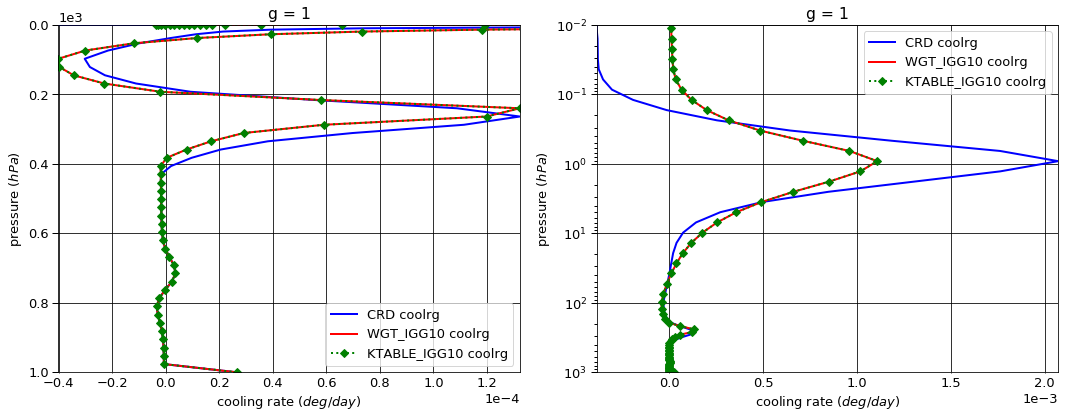

# Figure: cooling rate g-group 2

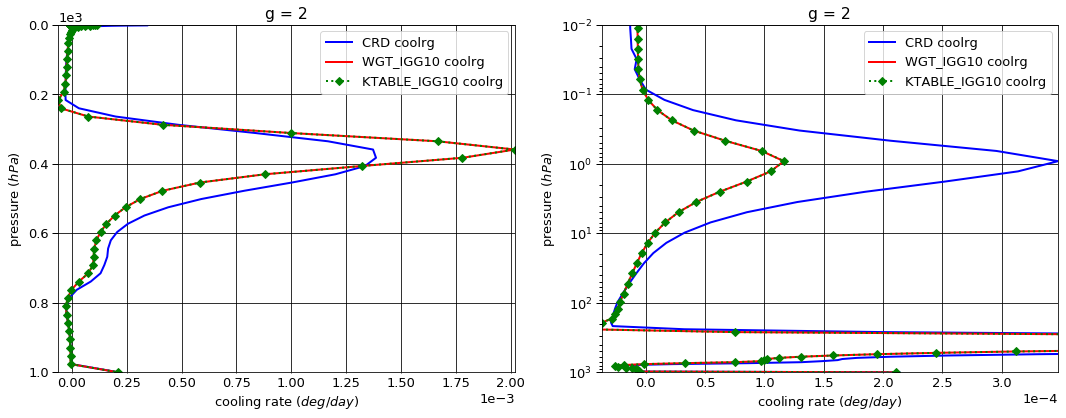

# Figure: cooling rate g-group 3

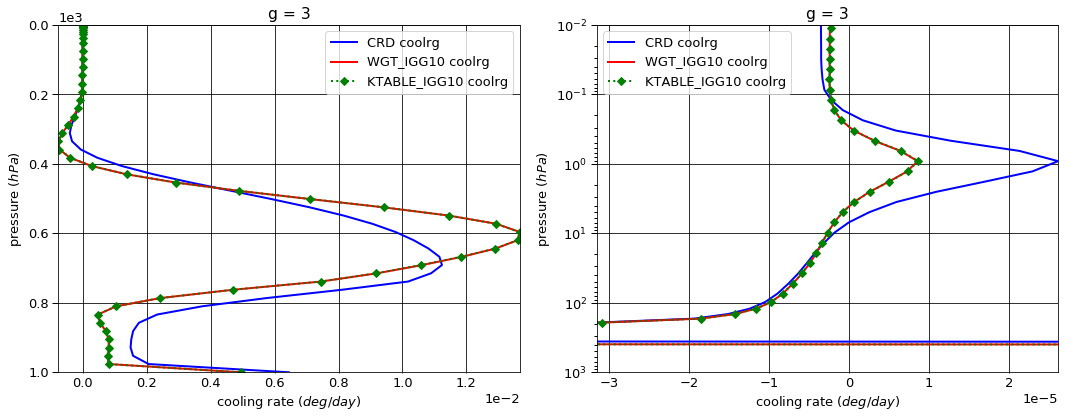

# Figure: cooling rate g-group 4

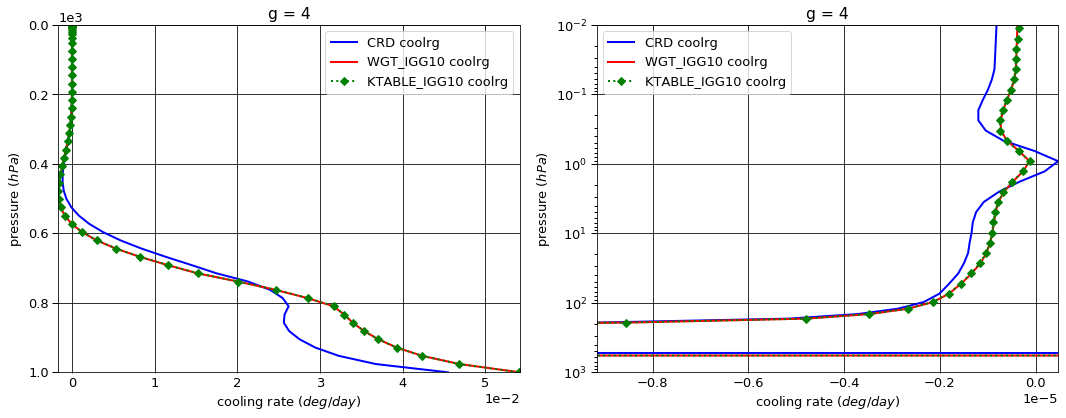

# Figure: cooling rate g-group 5

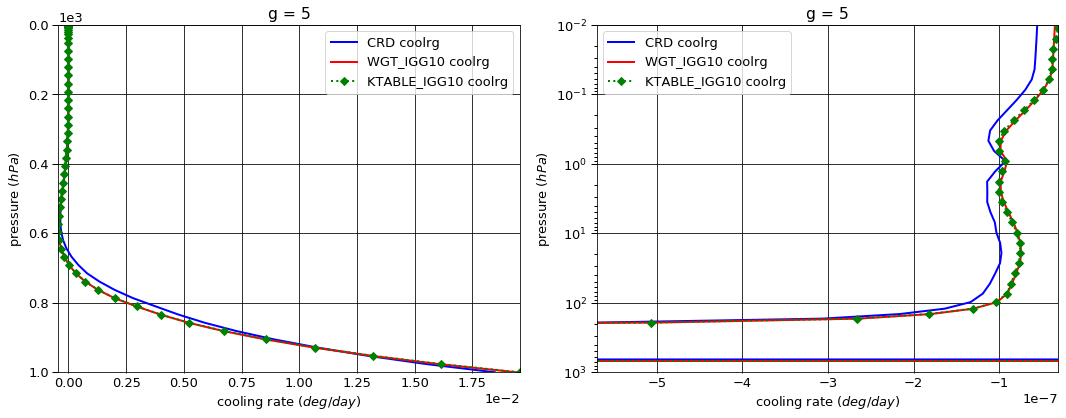

# Figure: cooling rate g-group total

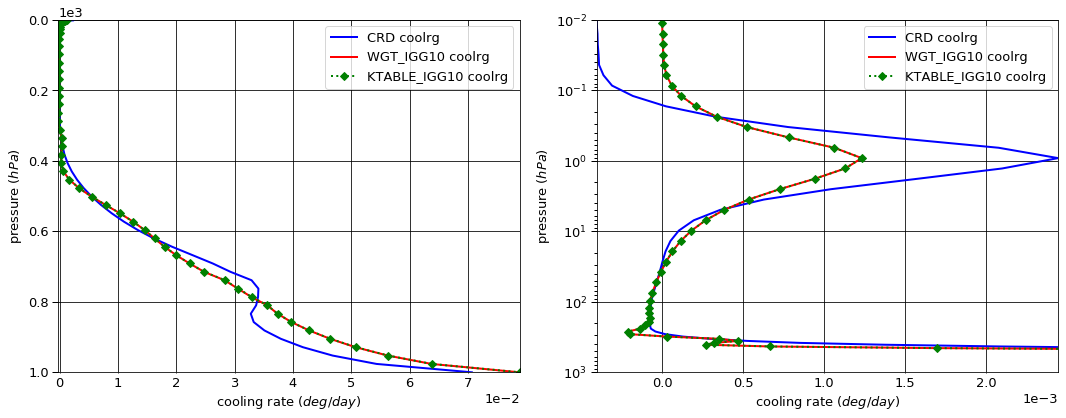

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001989  0.000000 -0.001989
  1013.0   76    -0.036512  0.036436 -0.000076
2 0.0      1     -0.035772  0.000000 -0.035772
  1013.0   76    -0.287305  0.286699 -0.000606
3 0.0      1     -0.447399  0.000000 -0.447399
  1013.0   76    -1.351192  1.329323 -0.021869
4 0.0      1     -1.844832  0.000000 -1.844832
  1013.0   76    -2.736536  2.024138 -0.712398
5 0.0      1     -3.644326  0.000000 -3.644326
  1013.0   76    -3.773594  0.390551 -3.383043


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001513  0.000000 -0.001513
  1013.0   76    -0.036512  0.036436 -0.000076
2 0.0      1     -0.033061  0.000000 -0.033061
  1013.0   76    -0.287305  0.286703 -0.000603
3 0.0      1     -0.418800  0.000000 -0.418800
  1013.0   76    -1.351192  1.338011 -0.013181
4 0.0      1     -1.829654  0.000000 -1.829654
  1013.0   76    -2.736536  2.197898 -0.538637
5 0.0      1     -3.652513  0.000000 -3.652513
  1013.0   76    -3.773594  0.366008 -3.407586


KTABLE_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001513  0.000000 -0.001513
  1013.0   76    -0.036512  0.036436 -0.000076
2 0.0      1     -0.033053  0.000000 -0.033053
  1013.0   76    -0.287305  0.286703 -0.000603
3 0.0      1     -0.418489  0.000000 -0.418489
  1013.0   76    -1.351192  1.338028 -0.013164
4 0.0      1     -1.828229  0.000000 -1.828229
  1013.0   76    -2.736536  2.199923 -0.536613
5 0.0      1     -3.651739  0.000000 -3.651739
  1013.0   76    -3.773594  0.368333 -3.405261


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      4.764085e-04  0.000000  0.000476
  1013.0   76     0.000000e+00  0.000000  0.000000
2 0.0      1      2.710928e-03  0.000000  0.002711
  1013.0   76     0.000000e+00  0.000003  0.000003
3 0.0      1      2.859969e-02  0.000000  0.028600
  1013.0   76     2.220446e-16  0.008688  0.008688
4 0.0      1      1.517780e-02  0.000000  0.015178
  1013.0   76     0.000000e+00  0.173761  0.173761
5 0.0      1     -8.187000e-03  0.000000 -0.008187
  1013.0   76     0.000000e+00 -0.024543 -0.024543


KTABLE_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      4.762877e-04  0.000000  0.000476
  1013.0   76     0.000000e+00  0.000000  0.000000
2 0.0      1      2.719104e-03  0.000000  0.002719
  1013.0   76     0.000000e+00  0.000003  0.000003
3 0.0      1      2.891052e-02  0.000000  0.028911
  1013.0   76     2.220446e-16  0.008705  0.008705
4 0.0      1      1.660280e-02  0.000000  0.016603
  1013.0   76     0.000000e+00  0.175785  0.175785
5 0.0      1     -7.412400e-03  0.000000 -0.007412
  1013.0   76     0.000000e+00 -0.022219 -0.022219

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.977086e-04
  1001.112500 75     2.659297e-05
2 0.000312    1     -6.939045e-06
  1001.112500 75     2.137292e-04
3 0.000312    1     -3.497767e-06
  1001.112500 75     6.447971e-03
4 0.000312    1     -7.422329e-07
  1001.112500 75     4.549236e-02
5 0.000312    1     -5.021809e-08
  1001.112500 75     1.847041e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -3.699679e-06
  1001.112500 75     2.659297e-05
2 0.000312    1     -7.906107e-06
  1001.112500 75     2.112815e-04
3 0.000312    1     -2.289555e-06
  1001.112500 75     4.944717e-03
4 0.000312    1     -3.293326e-07
  1001.112500 75     5.419963e-02
5 0.000312    1     -3.019450e-08
  1001.112500 75     1.942620e-02


KTABLE_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -3.646989e-06
  1001.112500 75     2.659297e-05
2 0.000312    1     -7.337654e-06
  1001.112500 75     2.112815e-04
3 0.000312    1     -1.978496e-06
  1001.112500 75     4.937400e-03
4 0.000312    1     -1.945621e-07
  1001.112500 75     5.414877e-02
5 0.000312    1     -1.846854e-08
  1001.112500 75     1.955120e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.940089e-04
  1001.112500 75     0.000000e+00
2 0.000312    1     -9.670621e-07
  1001.112500 75    -2.447690e-06
3 0.000312    1      1.208213e-06
  1001.112500 75    -1.503254e-03
4 0.000312    1      4.129003e-07
  1001.112500 75     8.707273e-03
5 0.000312    1      2.002359e-08
  1001.112500 75     9.557950e-04


KTABLE_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.940616e-04
  1001.112500 75     0.000000e+00
2 0.000312    1     -3.986092e-07
  1001.112500 75    -2.447690e-06
3 0.000312    1      1.519271e-06
  1001.112500 75    -1.510571e-03
4 0.000312    1      5.476708e-07
  1001.112500 75     8.656411e-03
5 0.000312    1      3.174955e-08
  1001.112500 75     1.080790e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.974318,0.000000,-5.974318
1013.0,76,-8.185140,4.067148,-4.117992



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.93554,0.000000,-5.935540
1013.0,76,-8.18514,4.225057,-3.960083



KTABLE_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.933022,0.000000,-5.933022
1013.0,76,-8.185140,4.229422,-3.955717



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.038778,0.000000,0.038778
1013.0,76,0.000000,0.157909,0.157909



KTABLE_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.041296,0.000000,0.041296
1013.0,76,0.000000,0.162274,0.162275


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000409
1001.112500,75,0.070651



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000014
1001.112500,75,0.078808



KTABLE_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000013
1001.112500,75,0.078875



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000395
1001.112500,75,0.008157



KTABLE_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000396
1001.112500,75,0.008224


In [21]:
table_dgdgs.display_dgdgs(crd)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001336,0.005408
2,0.011914,0.041776
3,0.068623,0.194239
4,0.253773,0.361773
5,0.664355,0.396805


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.335911e-20
2,5.630332e-22
3,2.372961e-23
4,1.000109e-24
5,6.466739e-29


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.335911e-20,NaN,0.001336,0.005408,0.001336,0.005408,500.0
2,5.630332e-22,0.042146,0.011914,0.041776,0.013250,0.047184,500.0
3,2.372961e-23,0.042146,0.068623,0.194239,0.081873,0.241423,500.0
4,1.000109e-24,0.042146,0.253773,0.361773,0.335645,0.603195,500.0
5,6.466739e-29,0.000065,0.664355,0.396805,1.000000,1.000000,500.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog        ratio        taulyr
layer g pressure                                                          
1     1 0.000312     4.301505e-20  1.635884e-21    26.294677  1.258459e-06
      2 0.000312     5.400089e-22  1.577092e-23    34.240807  1.560077e-08
      3 0.000312     7.566166e-24  3.929413e-25    19.255210  2.753590e-10
      4 0.000312     1.895479e-25  1.925699e-26     9.843070  8.402266e-12
      5 0.000312     6.032863e-27  4.818936e-30  1251.907700  3.757244e-13
2     1 0.000750     4.316239e-20  1.638024e-21    26.350275  5.085689e-07
      2 0.000750     5.420862e-22  1.580775e-23    34.292437  6.307557e-09
      3 0.000750     7.602792e-24  3.943403e-25    19.279776  1.114408e-10
      4 0.000750     1.914049e-25  1.936653e-26     9.883284  3.416595e-12
      5 0.000750     6.087127e-27  4.943162e-30  1231.423500  1.526982e-13
3     1 0.001052     4.346161e-20  1.642138e-21    26.466485  7.179841e-07
      2 0.001052     5.463199e-22  1.587680e-23    34.409952  8.913438e-09
      3 0.001052     7.677689e-24  3.970553e-25    19.336573  1.577997e-10
      4 0.001052     1.952247e-25  1.958318e-26     9.969004  4.884349e-12
      5 0.001052     6.198831e-27  5.057271e-30  1225.726600  2.180716e-13
4     1 0.001476     4.376585e-20  1.646370e-21    26.583240  1.014066e-06
      2 0.001476     5.506499e-22  1.594798e-23    34.527870  1.260190e-08
      3 0.001476     7.754689e-24  3.998557e-25    19.393716  2.235637e-10
      4 0.001476     1.991834e-25  1.980553e-26    10.056959  6.987326e-12
      5 0.001476     6.314682e-27  5.203477e-30  1213.550400  3.116488e-13
5     1 0.002070     4.407099e-20  1.650688e-21    26.698562  1.431902e-06
      2 0.002070     5.550186e-22  1.602090e-23    34.643419  1.781302e-08
      3 0.002070     7.832795e-24  4.027174e-25    19.449853  3.166811e-10
      4 0.002070     2.032313e-25  2.003126e-26    10.145707  9.994060e-12
      5 0.002070     6.433234e-27  5.394294e-30  1192.599700  4.453216e-13
6     1 0.002904     4.437693e-20  1.655120e-21    26.811910  2.022072e-06
      2 0.002904     5.594253e-22  1.609623e-23    34.755061  2.518202e-08
      3 0.002904     7.912011e-24  4.056573e-25    19.504177  4.486519e-10
      4 0.002904     2.073696e-25  2.026113e-26    10.234849  1.429683e-11
      5 0.002904     6.554529e-27  5.648023e-30  1160.499800  6.364489e-13
7     1 0.004074     4.468361e-20  1.659707e-21    26.922580  2.855489e-06
      2 0.004074     5.638701e-22  1.617497e-23    34.860658  3.560087e-08
      3 0.004074     7.992356e-24  4.086986e-25    19.555626  6.356665e-10
      4 0.004074     2.116003e-25  2.049626e-26    10.323851  2.045359e-11
      5 0.004074     6.678635e-27  5.988631e-30  1115.219000  9.097016e-13
8     1 0.005714     4.499120e-20  1.664512e-21    27.029660  4.032066e-06
      2 0.005714     5.683562e-22  1.625854e-23    34.957406  5.032819e-08
      3 0.005714     8.073914e-24  4.118770e-25    19.602731  9.006301e-10
      4 0.005714     2.159290e-25  2.073843e-26    10.412023  2.926171e-11
      5 0.005714     6.805715e-27  6.449200e-30  1055.280600  1.300308e-12
9     1 0.008015     4.529954e-20  1.669615e-21    27.131722  5.693475e-06
      2 0.008015     5.728829e-22  1.634885e-23    35.041167  7.115136e-08
      3 0.008015     8.156693e-24  4.152394e-25    19.643349  1.276151e-09
      4 0.008015     2.203573e-25  2.098989e-26    10.498259  4.186689e-11
      5 0.008015     6.935822e-27  7.074638e-30   980.378300  1.858845e-12
10    1 0.011243     4.560871e-20  1.675135e-21    27.226882  8.039240e-06
      2 0.011243     5.774528e-22  1.644869e-23    35.106304  1.005921e-07
      3 0.011243     8.240773e-24  4.188545e-25    19.674546  1.808364e-09
      4 0.011243     2.248904e-25  2.125401e-26    10.581082  5.990655e-11
      5 0.011243     7.069114e-27  7.924618e-30   892.044780  2.657530e-12
11    1 0.015771     4.591874e-20  1.681237e-21    27.312477  1.135157e-05
      2 0.015771     5.820684e-22  1.656192e-23    

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
